## A supervised learning based approach for homography estimation
- This is a Pilot code , later to be used for an end-toend image stitching model
- The model is trained on a Pascal VOC2012 dataset


In [ ]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar

--2021-03-24 14:43:43--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... ^C


In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!kaggle datasets list
!kaggle datasets download -d zaraks/pascal-voc-2007
!mv pascal-voc-2007.zip gdrive/MyDrive/homography/
!cd gdrive/MyDrive/homography/
!unzip pascal-voc-2007.zip

kaggle.json


In [ ]:
import glob
images = glob.glob('/content/gdrive/MyDrive/homography/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/*.jpg')

### Dataset generation 

In [ ]:
from matplotlib import pyplot as plt
import cv2
import random
import numpy as np
from numpy.linalg import inv
import os
import pandas as pd

#data_path = '/content/gdrive/MyDrive/homography/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages'
### This function is provided by Mez Gebre's repository "deep_homography_estimation"
#   https://github.com/mez/deep_homography_estimation
#   Dataset_Generation_Visualization.ipynb
def ImagePreProcessing(image,path):
    print(image)
    img = cv2.imread(path+'/%s'%image,0)
    if img is None:
      return None  
    if len(img.shape)!=0:
      img = cv2.resize(img,(320,240))

    rho          = 32
    patch_size   = 128
    top_point    = (32,32)
    left_point   = (patch_size+32, 32)
    bottom_point = (patch_size+32, patch_size+32)
    right_point  = (32, patch_size+32)
    test_image = img.copy()
    four_points = [top_point, left_point, bottom_point, right_point]

    perturbed_four_points = []
    for point in four_points:
        perturbed_four_points.append((point[0] + random.randint(-rho,rho), point[1]+random.randint(-rho,rho)))

    H = cv2.getPerspectiveTransform( np.float32(four_points), np.float32(perturbed_four_points) )
    H_inverse = inv(H)

    warped_image = cv2.warpPerspective(img,H_inverse, (320,240))

    annotated_warp_image = warped_image.copy()

    Ip1 = test_image[top_point[1]:bottom_point[1],top_point[0]:bottom_point[0]]
    Ip2 = warped_image[top_point[1]:bottom_point[1],top_point[0]:bottom_point[0]]

    training_image = np.dstack((Ip1, Ip2))
    H_four_points = np.subtract(np.array(perturbed_four_points), np.array(four_points))
    data = (training_image, H_four_points)
    
    return data, [four_points, perturbed_four_points, H_four_points, H_inverse]


# save .npy files 
def savedata(path):
  lst = os.listdir(path+'/')
  #os.makedirs('/content/gdrive/MyDrive/homography/processed/')
  new_path = '/content/gdrive/MyDrive/homography/processed/sample/sample_dataset/'
  os.chdir(new_path)
  c=0
  corners = {}
  for i in lst:
    j = i[:-5]
    file, corners[i] = ImagePreProcessing(i,path)
    if file == None:
      continue
    else:
      np.save('%s'%j,file, allow_pickle=True)
      #cv2.imwrite(f"{j}",ImagePreProcessing(i,path))
  return corners
#savedata(data_path)



In [ ]:
import glob
data = glob.glob('/content/gdrive/MyDrive/homography/processed/*')

In [ ]:
import shutil
val_size = int(len(data)*0.15)
os.mkdir('/content/gdrive/MyDrive/homography/processed/train/')
os.mkdir('/content/gdrive/MyDrive/homography/processed/val/')
os.mkdir('/content/gdrive/MyDrive/homography/processed/test/')

for i in data[:-2*val_size]:
  shutil.move(i, '/content/gdrive/MyDrive/homography/processed/train/')

for i in data[-2*val_size:-val_size]:
  shutil.move(i, '/content/gdrive/MyDrive/homography/processed/val/')

for i in data[-val_size:]:
  shutil.move(i, '/content/gdrive/MyDrive/homography/processed/test/')


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd gdrive/MyDrive/homography/processed/

/content/gdrive/MyDrive/homography/processed


### MODEL

In [ ]:
from glob import glob
from fastai.vision import *
import matplotlib.pyplot as plt
import cv2
import random
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torchsummary import summary


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = self.conv_block(2, 64, 3, max_pool=False,  padding=1)
    self.layer2 = self.conv_block(64, 64, 3, max_pool=True, padding=1)
    self.layer3 = self.conv_block(64, 64, 3, max_pool=False, padding=1)
    self.layer4 = self.conv_block(64, 64, 3, max_pool=True, padding=1)
    self.layer5 = self.conv_block(64, 128, 3, max_pool=False, padding=1)
    self.layer6 = self.conv_block(128, 128, 3, max_pool=True, padding=1)
    self.layer7 = self.conv_block(128, 128, 3, max_pool=False, padding=1)
    self.layer8 = self.conv_block(128, 128, 3, max_pool=False, padding=1)
    self.fc1 = nn.Linear(128*16*16, 1024)
    self.fc2 = nn.Linear(1024, 8)

  def conv_block(self, conv_in, conv_out,k_size,max_pool,  **kwargs):
    if max_pool:
      block = nn.Sequential(nn.Conv2d(in_channels=conv_in, out_channels=conv_out, kernel_size=k_size, **kwargs),
                          nn.BatchNorm2d(conv_out),
                          nn.LeakyReLU(negative_slope=0.1),
                          nn.MaxPool2d(2))
    else:
      block = nn.Sequential(nn.Conv2d(in_channels=conv_in, out_channels=conv_out, kernel_size=k_size, **kwargs),
                          nn.BatchNorm2d(conv_out),
                          nn.LeakyReLU(negative_slope=0.1))
    return block

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.layer5(x)
    x = self.layer6(x)
    x = self.layer7(x)
    x = self.layer8(x)
    x = x.reshape(-1, 128*16*16)
    x = self.fc1(x)
    x = self.fc2(x)
    
    return x
  

In [ ]:
class dataset(Dataset):
  def __init__(self, path):
    X=()
    Y=()
    lst = os.listdir(path)
    l = 0
    for i in lst:
      arr = np.load(path+'%s'%i, allow_pickle=True)
      x = torch.from_numpy((arr[0].astype(float)-127.5)/127.5)
      X = X+(x,)
      y = torch.from_numpy(arr[1].astype(float)/32.)
      Y =Y+(y,)
      l+=1
    
    self.len = l
    self.X_data = X
    self.Y_data = Y
  
  def __getitem__(self, index):
    return self.X_data[index], self.Y_data[index]
  def __len__(self):
    return self.len

In [ ]:
train_path = '/content/gdrive/MyDrive/homography/processed/train/'
val_path = '/content/gdrive/MyDrive/homography/processed/val/'
test_path = '/content/gdrive/MyDrive/homography/processed/test/'

In [ ]:
#training_dataset = dataset(train_path)
validation_dataset = dataset(val_path)
#test_dataset = dataset(test_path)

In [ ]:
batch_size = 64
Trainloader = DataLoader(training_dataset, batch_size)
Validationloader = DataLoader(validation_dataset, batch_size)
Testloader = DataLoader(test_dataset, batch_size)
criterion = nn.MSELoss()
num_samples = 3468
total_iterations = 2500
steps_per_epoch = int(num_samples / batch_size)
epochs = int(total_iterations / steps_per_epoch)
model = Model().to(device)
summary(model,(2, 128, 128))
optimizer = optim.SGD(model.parameters(), lr = 0.005, momentum=0.9)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,216
       BatchNorm2d-2         [-1, 64, 128, 128]             128
         LeakyReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
         LeakyReLU-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,928
       BatchNorm2d-9           [-1, 64, 64, 64]             128
        LeakyReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11           [-1, 64, 64, 64]          36,928
      BatchNorm2d-12           [-1, 64, 64, 64]             128
        LeakyReLU-13           [-1, 64, 64, 64]               0
        MaxPool2d-14           [-1, 64,

In [ ]:
for epoch in range(epochs):
  for i, (images, target) in enumerate(Trainloader):
    optimizer.zero_grad()
    images = images.to(device)
    target = target.to(device)
    images = images.permute(0, 3, 1, 2).float()
    target = target.float()
    outputs = model(images)
    loss = criterion(outputs, target.view(-1, 8))
    loss.backward()
    optimizer.step()
    if (i+1) % len(Trainloader) == 0:
      print('Train Epoch: [{}/{}] [{}/{} ({:.0f}%)]\Mean Squared Error: {:.6f}'.format(epoch+1, epochs, i, len(Trainloader),
                                                                                       100. *i / len(Trainloader), loss))
      


Train Epoch: [1/46] [54/55 (98%)]\Mean Squared Error: 0.120356
Train Epoch: [2/46] [54/55 (98%)]\Mean Squared Error: 0.114379
Train Epoch: [3/46] [54/55 (98%)]\Mean Squared Error: 0.150848
Train Epoch: [4/46] [54/55 (98%)]\Mean Squared Error: 0.171522
Train Epoch: [5/46] [54/55 (98%)]\Mean Squared Error: 0.117746
Train Epoch: [6/46] [54/55 (98%)]\Mean Squared Error: 0.317206
Train Epoch: [7/46] [54/55 (98%)]\Mean Squared Error: 0.401419
Train Epoch: [8/46] [54/55 (98%)]\Mean Squared Error: 0.111678
Train Epoch: [9/46] [54/55 (98%)]\Mean Squared Error: 0.114024
Train Epoch: [10/46] [54/55 (98%)]\Mean Squared Error: 0.103398
Train Epoch: [11/46] [54/55 (98%)]\Mean Squared Error: 0.114620
Train Epoch: [12/46] [54/55 (98%)]\Mean Squared Error: 0.153965
Train Epoch: [13/46] [54/55 (98%)]\Mean Squared Error: 0.248077
Train Epoch: [14/46] [54/55 (98%)]\Mean Squared Error: 0.273715
Train Epoch: [15/46] [54/55 (98%)]\Mean Squared Error: 0.270867
Train Epoch: [16/46] [54/55 (98%)]\Mean Squared E

In [ ]:
state = {'epoch':epoch, 'state_dict':model.state_dict(), 'optimizer':optimizer.state_dict()}
torch.save(state, 'homography_estimation.pth')
torch.save(model.state_dict(),'model_homograhpy_estimation.pth')

### Evaluation on samples

In [ ]:
sample_corners = savedata('/content/gdrive/MyDrive/homography/processed/sample/original_image')
samples_dataset = dataset('/content/gdrive/MyDrive/homography/processed/sample/sample_dataset/')
sample_path = '/content/gdrive/MyDrive/homography/processed/sample/sample_dataset/'
sample_data = dataset(sample_path)

In [ ]:
model = Model().to(device)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/homography/processed/model_homograhpy_estimation.pth'))


<All keys matched successfully>

In [ ]:
batch_size = 1
sampleloader = DataLoader(sample_data, batch_size)
#Testloader = DataLoader(test_dataset, batch_size)
criterion = nn.MSELoss()
num_samples = 3468
total_iterations = 2500
steps_per_epoch = int(num_samples / batch_size)
epochs = int(total_iterations / steps_per_epoch)
optimizer = optim.SGD(model.parameters(), lr = 0.005, momentum=0.9)


In [ ]:
model.eval()
predictions = []
losses = []
images_list=[]
with torch.no_grad():
    for i,(images, target) in enumerate(sampleloader):
        images = images.to(device)
        target = target.to(device)
        images = images.permute(0,3,1,2).float()
        target = target.float()
        outputs = model(images)
        loss = criterion(outputs, target.view(-1,8))
        losses.append(loss)
        images_list.append(images)
        predictions.append(outputs)
        print(f'{target.view(-1, 8)*32}   ||   {outputs*32}')
        if loss is None:
          continue
    print('\Mean Squared Error: {:.6f}'.format(np.sum(losses)/len(losses)))

tensor([[-29., -11., -11., -16.,   5.,  -5.,  20.,  -5.]], device='cuda:0')   ||   tensor([[ 15.2266, -10.9726,   9.2516, -11.3399,  25.8539, -22.8648,  39.4547,
           4.0827]], device='cuda:0')
tensor([[  8.,   3.,  16., -29.,  -4.,  13., -30.,  -5.]], device='cuda:0')   ||   tensor([[ 12.5568,  12.3232,   7.8110,  -9.8330,   1.7597, -17.2737,   2.2455,
          -6.8114]], device='cuda:0')
tensor([[ -6., -30.,   4.,   9.,  26.,  31., -19.,   8.]], device='cuda:0')   ||   tensor([[-2.1801e-02, -3.9101e+01, -7.4339e+00,  1.9091e+01,  2.0241e+01,
         -1.1649e+01, -1.4330e+01,  2.3862e+00]], device='cuda:0')
\Mean Squared Error: 0.341564


In [ ]:
#print(predictions[2] *32)
source_corners = np.array(sample_corners['m3.jfif'][0]) ## original image corners (source image) for sample m3
four_point_h = np.array(predictions[2].cpu().view(4,2) *32) ## prediction for sample m3
perturbed_corner = np.add(source_corners, four_point_h) ##perturbed corners according to prediction
homo_matrix = cv2.getPerspectiveTransform(np.float32(source_corners), np.float32(perturbed_corner)) ##homogrpahy matrix for predictions , from source to destination

In [ ]:
print(homo_matrix) ## predicted
print(sample_corners['m3.jfif'][-1]) ## ground truth

[[ 1.912311e+00 -1.774985e-01 -2.082100e+01]
 [ 7.913437e-01  9.198025e-01 -6.246077e+01]
 [ 5.835100e-03 -3.182107e-03  1.000000e+00]]
[[ 1.384474e+00 -3.269960e-01  1.109331e+01]
 [ 3.535873e-01  8.652468e-01 -1.456232e+01]
 [ 2.018593e-03 -1.480021e-03  1.034569e+00]]


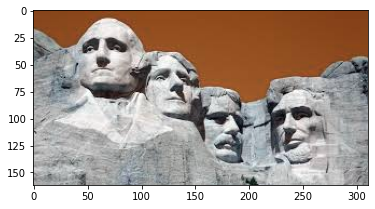

In [ ]:
image_3 = cv2.imread('/content/gdrive/MyDrive/homography/processed/sample/original_image/m3.jfif')
plt.imshow(image_3)

In [ ]:
original = images_list[0][0][0,:,:].permute(0,1).cpu()
print(images_list[0][0].shape)
perturbed_image = images_list[0][0][1,:,:].permute(0,1).cpu()

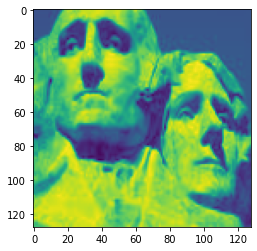

In [ ]:
plt.imshow(original)

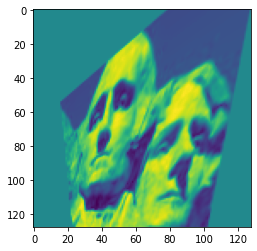

In [ ]:
new_image = cv2.warpPerspective(np.array(perturbed_image),inv(homo_matrix),(128,128))
plt.imshow(new_image)